# PS3

MACS 30100 Dr. Evens

Jie Heng

## Problem 1

In [1]:
import numpy as np
import numpy.linalg as lin
import pandas as pd
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')
# This next command is specifically for Jupyter Notebook
%matplotlib notebook

inc = np.loadtxt('incomes.txt')
inc.size

200

### (a) plot a histogram

<IPython.core.display.Javascript object>


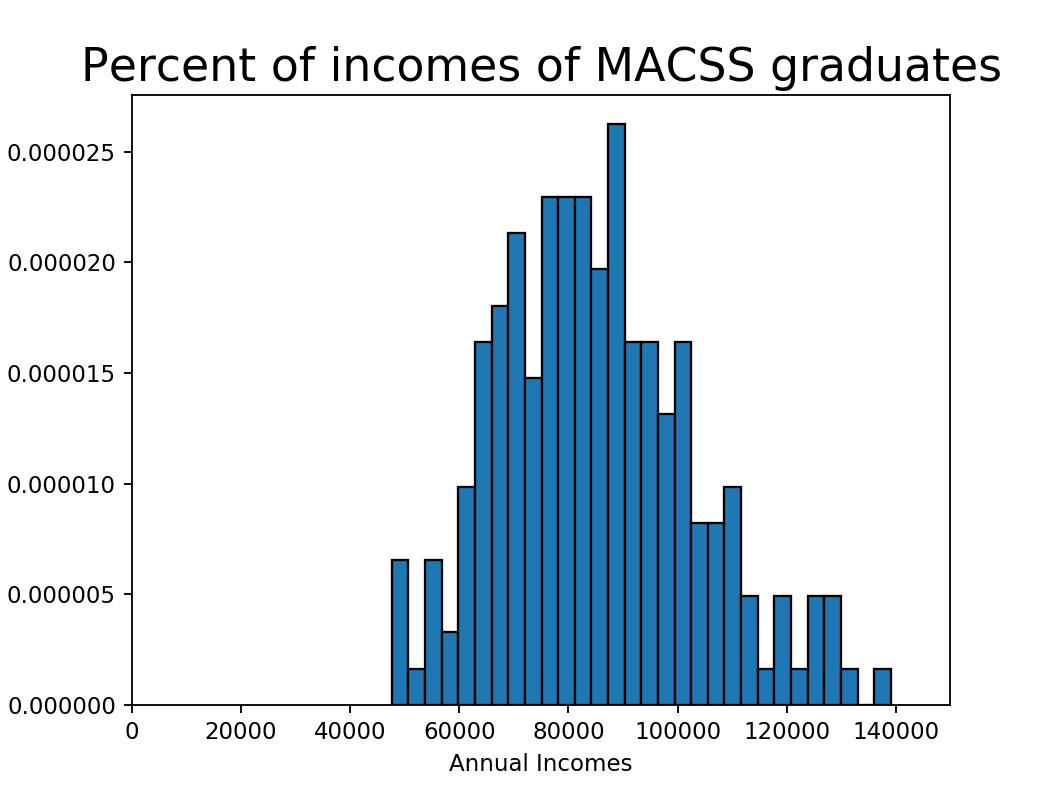

In [2]:
%matplotlib notebook
p1_a= plt.figure()
plt.hist(inc, 30, edgecolor='black', normed=True)
plt.title('Percent of incomes of MACSS graduates', fontsize=20)
plt.xlabel('Annual Incomes')
plt.ylabel('Percent of Observations')
plt.xlim([0, 150000])
plt.savefig('p1-a.png')
plt.show()

### (b) Estimate the parameters of the lognormal distribution by generalized method,of moments. Use the average income and standard deviation of income as your two moments. Use the identity matrix as your weighting matrix Wˆ . Plot your estimated lognormal PDF against the histogram from part (a). Report the value of your GMM criterion function at the estimated parameter values. Report and compare your two data moments against your two model moments at the estimated parameter values.

In [3]:
def trunc_lognorm_pdf(xvals, mu, sigma, cutoff):
    if cutoff == 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(0, loc=mu, s=sigma, scale=1)
    else:
        prob_notcut = (sts.lognorm.cdf(cutoff, loc=mu, s=sigma, scale=1) -
                       sts.lognorm.cdf(0, loc=mu, s=sigma, scale=1))
            
    pdf_vals    = ((1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    return pdf_vals

def data_moments(xvals):
    mean_data = xvals.mean()
    std_data = xvals.std()
    return mean_data, std_data

def model_moments(mu, sigma, cutoff):
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cutoff)
    (mean_model, m_m_err) = intgr.quad(xfx, 0.01, cutoff)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma, cutoff) 
    (var_model, v_m_err) = intgr.quad(x2fx, 0.01, cutoff)
    std_model = np.sqrt(var_model)
    return mean_model, std_model

def err_vec(xvals, mu, sigma, cutoff, simple):
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cutoff)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    return err_vec

def criterion(params, *args):
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    return crit_val

In [4]:
mu_init = 11
sig_init = 0.8
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (inc, 150000, W_hat)
results1 = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results1.x
criterion1 = criterion(results1.x, inc, 150000,W_hat).reshape(1,)[0]
print('mu: ', mu_GMM1, ' sigma: ', sig_GMM1, ' criterion value: ', criterion1)

mu:  11.3369104136  sigma:  0.213026928697  criterion value:  3.26158163041e-13


In [5]:
results1

      fun: array([[  3.26158163e-13]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -6.75322894e-07,  -4.54725646e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 42
      nit: 10
   status: 0
  success: True
        x: array([ 11.33691041,   0.21302693])

In [6]:
mean_data, std_data = data_moments(inc)
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1, 150000)
err1 = err_vec(inc, mu_GMM1, sig_GMM1, 150000, False).reshape(2,)
print('Mean of points =', mean_data, ', Standard deviation of points =', std_data)
print('Mean of model =', mean_model, ', Standard deviation of model =', std_model)
print('Error vector=', err1)

Mean of points = 85276.8236063 , Standard deviation of points = 17992.542128
Mean of model = 85276.82920071215 , Standard deviation of model = 17992.5319205
Error vector= [  6.56034524e-08  -5.67322087e-07]


<IPython.core.display.Javascript object>


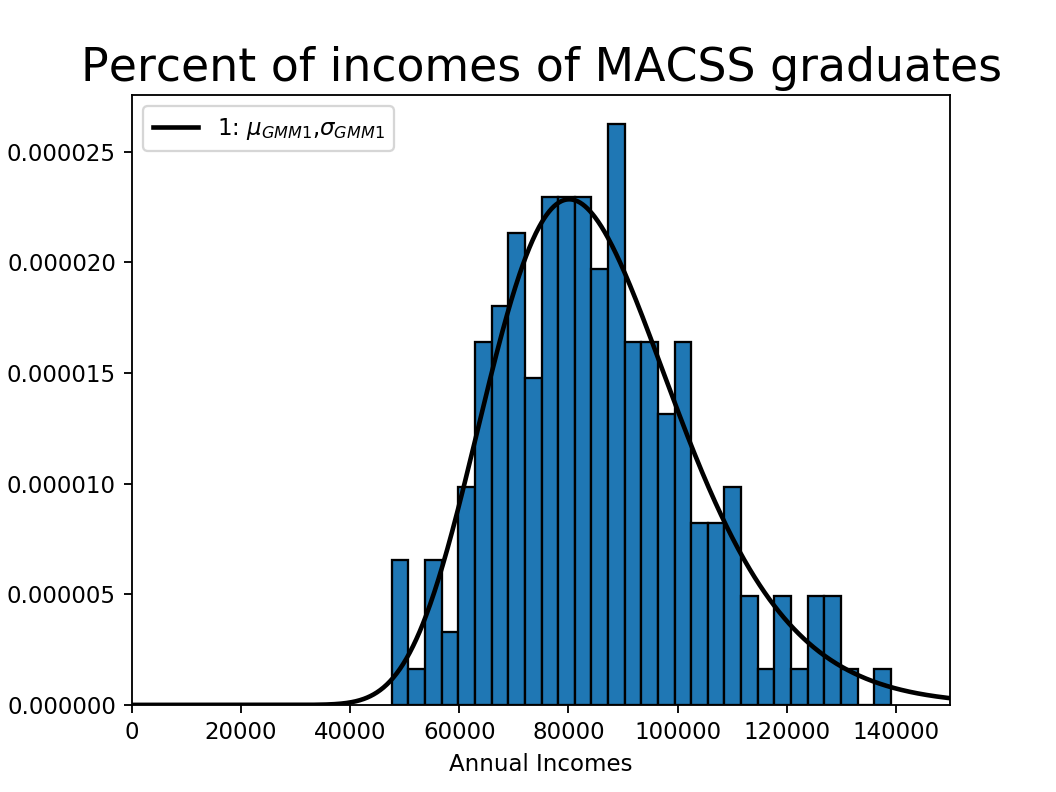

In [7]:
%matplotlib notebook
p1_b = plt.figure()
plt.hist(inc, 30, edgecolor='black', normed=True)
plt.title('Percent of incomes of MACSS graduates', fontsize=20)
plt.xlabel('Annual Incomes')
plt.ylabel('Percent of Observations')
plt.xlim([0, 150000])
dist_inc = np.linspace(1e-10, 150000, 1000)
plt.plot(dist_inc, trunc_lognorm_pdf(dist_inc, mu_GMM1, sig_GMM1, 150000),
         linewidth=2, color='k', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')
plt.savefig('p1-b.png')

### (c) Perform the two-step GMM estimator by using your estimates from part(b), Report your estimates as well as the criterion function value at these estimates. Plot your estimated lognormal PDF against the histogram from part (a) and the estimated PDF from part (b). Report and compare your two data moments against your two model moments at the estimated parameter values.

In [8]:
err1 = err_vec(inc, mu_GMM1, sig_GMM1, 150000, False)
VCV2 = np.dot(err1, err1.T) / inc.shape[0]
print('VCV2\n', VCV2)
W_hat2 = lin.pinv(VCV2) 
print('W_hat2\n',W_hat2)

VCV2
 [[  2.15190648e-17  -1.86091437e-16]
 [ -1.86091437e-16   1.60927175e-15]]
W_hat2
 [[  8.09145979e+12  -6.99729006e+13]
 [ -6.99729006e+13   6.05107971e+14]]


In [10]:
params_init2 = np.array([mu_GMM1, sig_GMM1])
gmm_args2 = (inc, 150000, W_hat2)
results2 = opt.minimize(criterion, params_init2, args=(gmm_args2),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x
criterion2 = criterion(results2.x, inc, 150000,W_hat2).reshape(1,)[0]
print('mu:', mu_GMM2, ' sigma:', sig_GMM2,' criterion value:', 
      criterion2)
mean_model, sd_model = model_moments(mu_GMM2, sig_GMM2, 150000)

C:\Users\hengj\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
C:\Users\hengj\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


mu: 11.3369104337  sigma: 0.213027062368  criterion value: 0.0264491178701


<IPython.core.display.Javascript object>


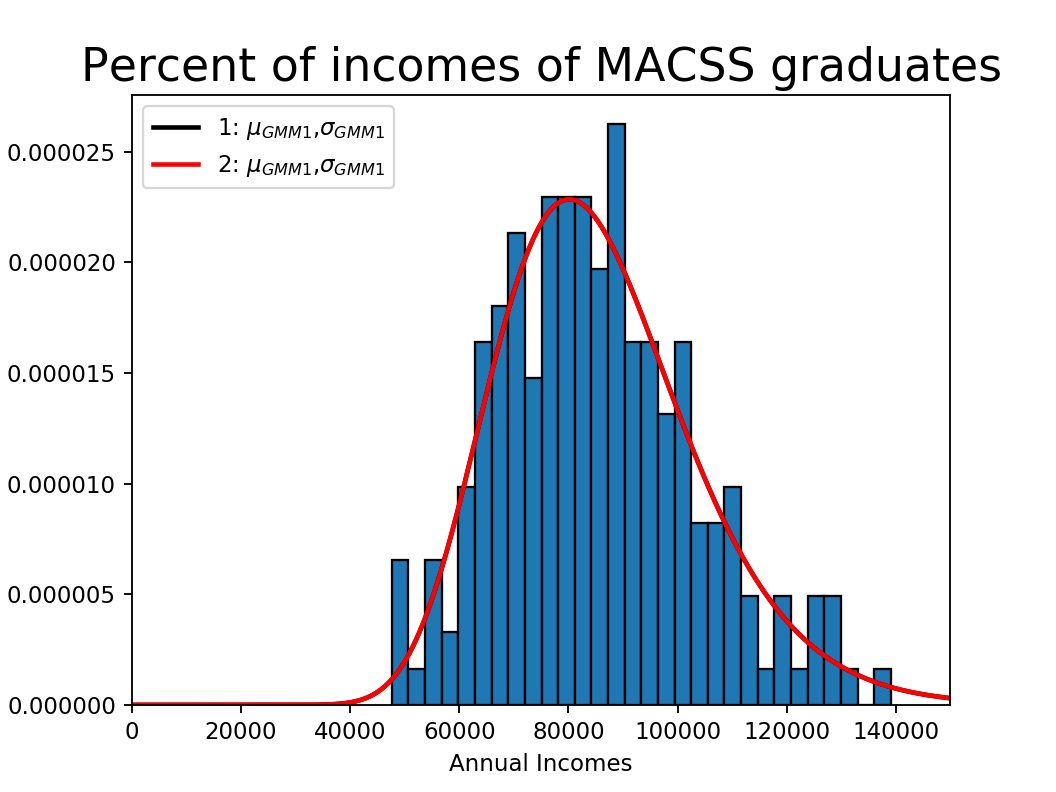

In [12]:
%matplotlib notebook
p1_c = plt.figure()
plt.hist(inc, 30, edgecolor='black', normed=True)
plt.title('Percent of incomes of MACSS graduates', fontsize=20)
plt.xlabel('Annual Incomes')
plt.ylabel('Percent of Observations')
plt.xlim([0, 150000])
dist_inc = np.linspace(1e-10, 150000, 1000)
plt.plot(dist_inc, trunc_lognorm_pdf(dist_inc, mu_GMM1, sig_GMM1, 150000),
         linewidth=2, color='k', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')
plt.plot(dist_inc, trunc_lognorm_pdf(dist_inc, mu_GMM1, sig_GMM1, 150000),
         linewidth=2, color='r', label='2: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')
plt.savefig('p1-b.png')

In [13]:
mean_model2, std_model2 = model_moments(mu_GMM2, sig_GMM2, 150000.0)
print('Mean of the first model is:', mean_model,'\n' 
     'Mean of the second model is:', mean_model2, '\n' 
     'Standard deviation of the first model is:', std_model, '\n' 
     'Standard deviation of the second model is:', std_model2, '\n' )
err2 = err_vec(inc, mu_GMM2, sig_GMM2, 150000, False)

Mean of the first model is: 85276.83054633468 
Mean of the second model is: 85276.83054633468 
Standard deviation of the first model is: 17992.5319205 
Standard deviation of the second model is: 17992.5421784 



### (d) Estimate the lognormal PDF to fit the data by GMM using 3 different moments.

In [14]:
def data_moments3(xvals):
    
    bpct_1_dat = xvals[(xvals >= 0.1) & (xvals < 75000.0)].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000.0) & (xvals < 100000.0)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = (xvals[(xvals >=100000.0) & (xvals < 150000.0)].shape[0] /
                  xvals.shape[0])
    return bpct_1_dat, bpct_2_dat, bpct_3_dat

def model_moments3(mu, sigma, cutoff):
    
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cutoff)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.1, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 150000)    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

def err_vec3(xvals, mu, sigma, cutoff, simple):

    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma, cutoff)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec

def criterion3(params, *args):

    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec3(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [38]:
W_hat = np.eye(3)
gmm_args = (inc, 150000.0, W_hat)
mu_init = 11
sig_init = 0.8
params_init = np.array([mu_init, sig_init])

results_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1_3, sig_GMM1_3 = results_3.x
criterion1_3 = criterion3(([mu_GMM1_3, sig_GMM1_3]), inc, 150000, W_hat).reshape(1,)[0]
print('mu_GMM1_3=', mu_GMM1_3, ' sig_GMM1_3=', sig_GMM1_3,"criterion value:", criterion1_3)

mu_GMM1_3= 11.3367266467  sig_GMM1_3= 0.211746420313 criterion value: 0.23818173309


In [16]:
print('data moments:',data_moments3(inc))
print('model moments:', model_moments3(mu_GMM1_3, sig_GMM1_3, 150000))

data moments: (0.3, 0.5, 0.2)
model moments: (0.29927245369350775, 0.4980574551619897, 0.1996627832819774)


<IPython.core.display.Javascript object>


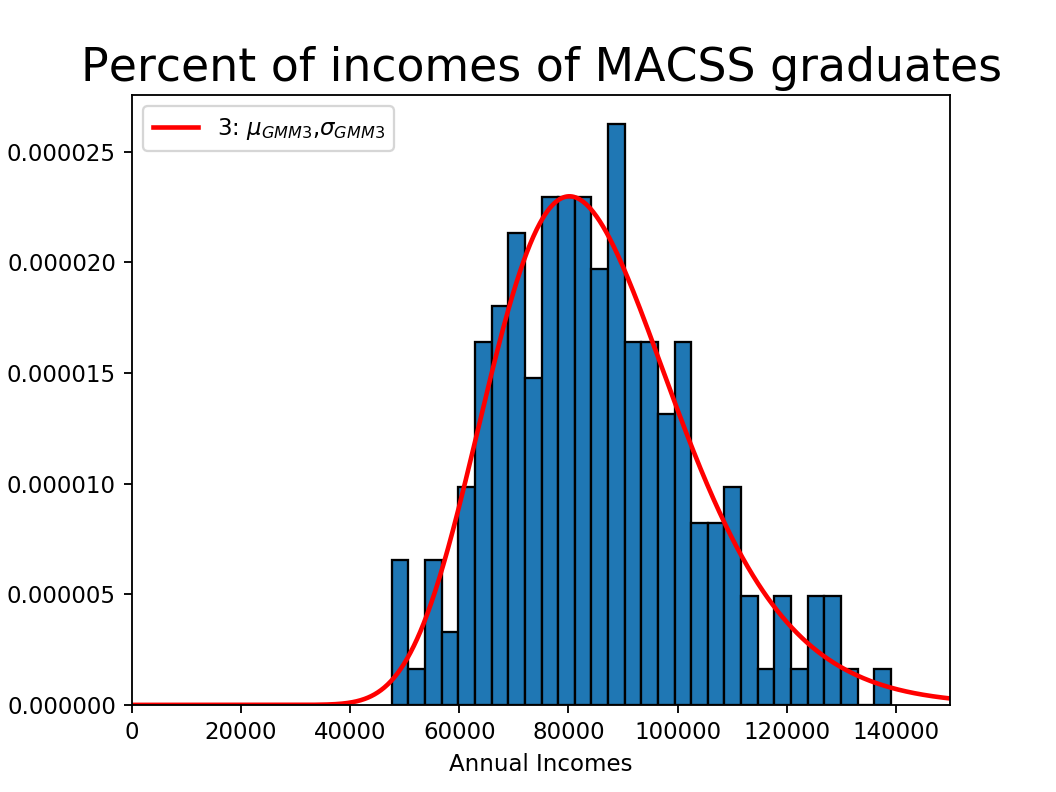

In [33]:
%matplotlib notebook
p1_d = plt.figure()
plt.hist(inc, 30, edgecolor='black', normed=True)
plt.title('Percent of incomes of MACSS graduates', fontsize=20)
plt.xlabel('Annual Incomes')
plt.ylabel('Percent of Observations')
plt.xlim([0, 150000])
dist_pts = np.linspace(1e-10, 150000, 1000)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1_3, sig_GMM1_3, 150000),
         linewidth=2, color='r', label='3: $\mu_{GMM3}$,$\sigma_{GMM3}$')
plt.legend(loc='upper left')
plt.savefig('p1-d.png')

### (e) Perform the two-step GMM estimator by using your estimates from part (d) with three moments

In [39]:
err1_3 = err_vec3(inc, mu_GMM1_3, sig_GMM1_3, 150000, False)
VCV2_3 = np.dot(err1_3, err1_3.T) / inc.shape[0]
print('VCV\n',VCV2_3)
W_hat2_3 = lin.pinv(VCV2_3) 
print('W_hat2_3',W_hat2_3)

VCV
 [[ 0.00029407  0.0004711   0.00020445]
 [ 0.0004711   0.0007547   0.00032753]
 [ 0.00020445  0.00032753  0.00014214]]
W_hat2_3 [[ 207.34429541  332.16479794  144.15564255]
 [ 332.16479794  532.12678349  230.93680868]
 [ 144.15564255  230.93680868  100.22387758]]


In [23]:
params_init2_3 = np.array([mu_GMM1_3, sig_GMM1_3])
gmm_args2_3 = (inc, 150000.0, W_hat2_3)
results2_3 = opt.minimize(criterion3, params_init2_3, args=(gmm_args2_3),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2_3, sig_GMM2_3 = results2_3.x
criterion2_3 = criterion3(([mu_GMM2_3, sig_GMM2_3]), inc, 150000, W_hat2_3).reshape(1,)[0]
print("mu:",mu_GMM2_3, "sigma:",sig_GMM2_3, "criterion value:", criterion2_3)

mu: 11.5899244672 sigma: 0.169919127046 criterion value: 1.67039541921e-11


In [37]:
print('data moments:', data_moments3(inc))
print('model moments:', model_moments3(mu_GMM2_3, sig_GMM2_3, 150000))

data moments: (0.3, 0.5, 0.2)
model moments: (0.015928361622051697, 0.3092916877322361, 0.6481663584108986)


<IPython.core.display.Javascript object>


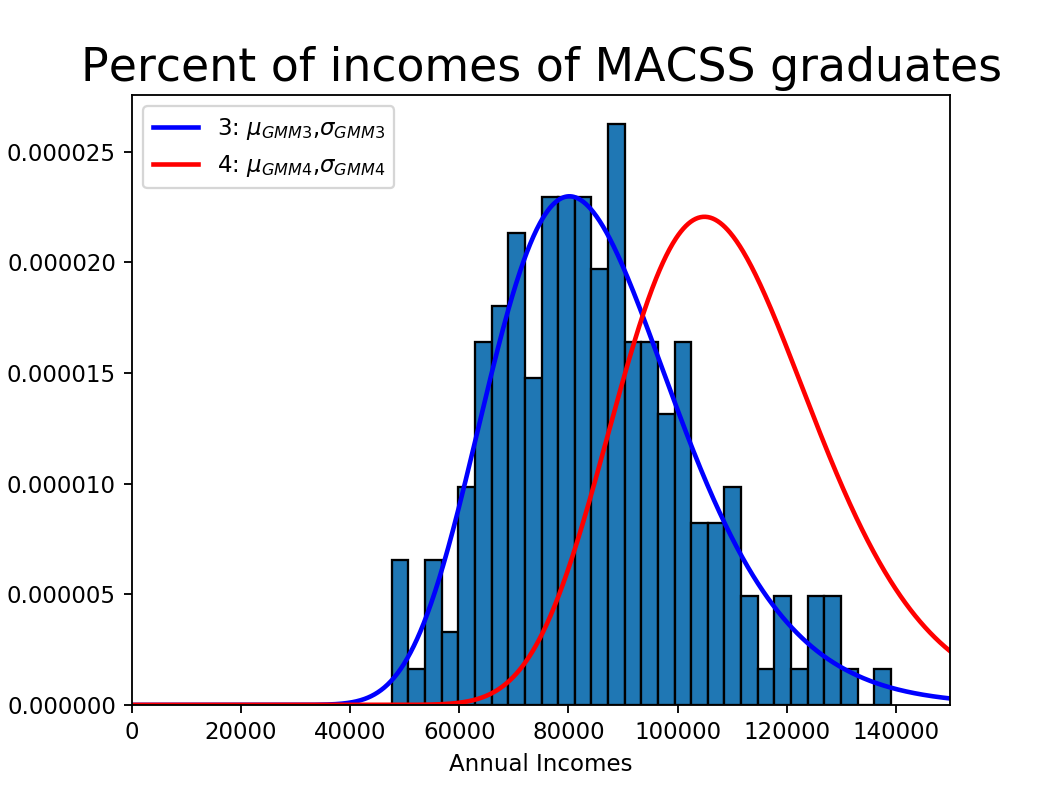

In [36]:
%matplotlib notebook
p1_d = plt.figure()
plt.hist(inc, 30, edgecolor='black', normed=True)
plt.title('Percent of incomes of MACSS graduates', fontsize=20)
plt.xlabel('Annual Incomes')
plt.ylabel('Percent of Observations')
plt.xlim([0, 150000])
dist_pts = np.linspace(1e-10, 150000, 1000)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1_3, sig_GMM1_3, 150000),
         linewidth=2, color='b', label='3: $\mu_{GMM3}$,$\sigma_{GMM3}$')
plt.legend(loc='upper left')
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM2_3, sig_GMM2_3, 150000),
         linewidth=2, color='r', label='4: $\mu_{GMM4}$,$\sigma_{GMM4}$')
plt.legend(loc='upper left')
plt.savefig('p1-d.png')

### (f) Which one is better

In [26]:
err1_4 = err_vec3(inc, mu_GMM2_3, sig_GMM2_3, 150000, False)
print(err1)
print(err2)
print(err1_3)
print(err1_4)

[[  6.56034524e-08]
 [ -5.67322087e-07]]
[[  8.13829159e-08]
 [  2.79954537e-09]]
[[-0.24251544]
 [-0.38850897]
 [-0.16860836]]
[[ -94.69054613]
 [ -38.14166245]
 [ 224.08317921]]


From my point of view, b,c,d fit the model very well. But judged by the value of error vectors, d is the best estimation.

## Problem 2

In [27]:
df = pd.read_csv('sick.txt', sep=",", header=0)
n = df.shape[0]

In [28]:
def data_moment(xvals):
    return xvals.sick

def model_moment(xvals,b0,b1,b2,b3):
    result = b0 + b1 * xvals["age"] + b2 * xvals["children"] + b3 * xvals["avgtemp_winter"]
    return result

def err_vec(xvals, b0,b1,b2,b3):
    data_mom = data_moment(xvals)
    moms_data = np.array(data_mom)
    model_mom = model_moment(xvals,b0,b1,b2,b3)
    moms_model = np.array(model_mom)
    err_vec = (moms_model - moms_data) / moms_data
    return err_vec

def criterion(params, *args):
    b0,b1,b2,b3 = params     
    xvals, W = args
    err = err_vec(xvals, b0,b1,b2,b3)
    crit_val = np.dot(np.dot(err.T, W), err) 
    return crit_val

In [29]:
params_init = np.array([0, 0, 0, 1])
W_hat = np.eye(200)
gmm_args = (df, W_hat)
results = opt.minimize(criterion, params_init, gmm_args, method='L-BFGS-B', \
                       bounds=((None, None), (None, None), (None, None), (None, None)))

In [30]:
b0, b1, b2, b3 = results.x
print('b0：', b0, '，b1：', b1, '，b2：', b2, '，b3：', b3)
print("criterion is: ", results.fun)

b0： 0.252222757161 ，b1： 0.0130231997756 ，b2： 0.399763493283 ，b3： -0.0100603533393
criterion is:  0.0148567888906


In [55]:
results

      fun: 0.014856788890576048
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -6.49254955e-06,   5.80309134e-03,   1.48929480e-05,
         8.97804175e-03])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 415
      nit: 38
   status: 2
  success: False
        x: array([ 0.25222276,  0.0130232 ,  0.39976349, -0.01006035])